In [298]:
#M. Bach
import sys 
if '..' not in sys.path:
    sys.path.append('../')
from utils import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd

data_path = '../data.hdf5'

data_dict = load_data(data_path, verbose=False)

start=0
stop=5_000

tango_ori = data_dict['pose/tango_ori'][start:stop]  
acc = data_dict['synced/acce'][start:stop]

y = data_dict['pose/tango_pos'][start:stop] - np.roll(data_dict['pose/tango_pos'][start:stop],shift=-1,axis=0)
y[0,:] = np.array([0,0,0])
X = np.concatenate((acc, tango_ori),axis=1)
#print(y)
#print(data_dict['pose/tango_pos'][start:stop])

In [299]:
Ntot = acc.shape[0]
print("Total no. of data points: ", Ntot)

#__________ HYPER PARAMETERS _________
# Set no. of layers in model
Nlayers = 30
# Set neurons per layer in model
hidden_size = 128
# Set learning rate
learning_rate = 0.0001
# Set loss function
criterion = nn.L1Loss()
# set n_epochs
num_epochs = 600
# Set how many observations to combine into one datapoint
group_num = 30 # EFFECT: By grouping, we are only giving the model 1 true orientation for every group_num measurements.

Total no. of data points:  5000


In [300]:
dt = data_dict['synced/time'][1:N+1] - data_dict['synced/time'][0:N]
dt = np.mean(dt)
"""
class Net(nn.Module):
    def __init__(self, input_size=13, output_size=16, hidden_size=16, num_layers=2):
        super(Net, self).__init__()
        self.num_layers = num_layers
        self.fc_input = nn.Linear(input_size, hidden_size)
        hidden_layers = []
        for i in range(self.num_layers):
            hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.hidden_layers = nn.ModuleList(hidden_layers)

        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #print(x)
        x = F.relu(self.fc_input(x))
        for i in range(self.num_layers):
            x = F.relu(self.hidden_layers[i](x))
            
        x = self.fc_output(x)
        return x

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

net = Net(input_size=X.shape[1], output_size=4, hidden_size=hidden_size, num_layers=Nlayers)

# mount model to device
net.to(device)
# number of params
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)
"""

"\nclass Net(nn.Module):\n    def __init__(self, input_size=13, output_size=16, hidden_size=16, num_layers=2):\n        super(Net, self).__init__()\n        self.num_layers = num_layers\n        self.fc_input = nn.Linear(input_size, hidden_size)\n        hidden_layers = []\n        for i in range(self.num_layers):\n            hidden_layers.append(nn.Linear(hidden_size, hidden_size))\n        self.hidden_layers = nn.ModuleList(hidden_layers)\n\n        self.fc_output = nn.Linear(hidden_size, output_size)\n\n    def forward(self, x):\n        #print(x)\n        x = F.relu(self.fc_input(x))\n        for i in range(self.num_layers):\n            x = F.relu(self.hidden_layers[i](x))\n            \n        x = self.fc_output(x)\n        return x\n\n# setting device on GPU if available, else CPU\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\nprint('Using device:', device)\n\n#Additional Info when using cuda\nif device.type == 'cuda':\n    print(torch.cuda.get_device_

In [301]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=False)

# convert to torch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

train_size = int(0.8 * X.shape[0])
train_input, test_input = X[:train_size], X[train_size:]
train_labels, test_labels = y[:train_size], y[train_size:]

# Convert the data to PyTorch tensors
train_input = torch.tensor(train_input, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)

test_input = torch.tensor(test_input, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

# Define the neural network architecture
class PositionPredictionModel(nn.Module):
    def __init__(self):
        super(PositionPredictionModel, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = PositionPredictionModel()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
batch_size = 1
num_batches = train_size // batch_size

for epoch in range(num_epochs):
    running_loss = 0.0
    n_minibatches = 0
    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = start_idx + batch_size

        batch_input = train_input[start_idx:end_idx]
        batch_labels = train_labels[start_idx:end_idx]

        optimizer.zero_grad()

        output = model(batch_input)
        loss = criterion(output, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        n_minibatches += 1
        
    print('Epoch %d, loss: %.10f' % (epoch+1, running_loss))

# Evaluate the model
with torch.no_grad():
    test_output = model(test_input)
    test_loss = criterion(test_output, test_labels)
    print(test_input)
    print(test_labels)
    print('Test loss:', test_loss.item())



Epoch 1, loss: 3.3741309351
Epoch 2, loss: 0.5080055290
Epoch 3, loss: 0.2310958986
Epoch 4, loss: 0.2300352404
Epoch 5, loss: 0.0002857889
Epoch 6, loss: 0.0000402200
Epoch 7, loss: 0.0000118803
Epoch 8, loss: 0.0001914645
Epoch 9, loss: 0.0000004665
Epoch 10, loss: 0.0000026382
tensor([[ 2.2520, -9.5284,  0.3511,  ...,  0.6078,  0.3108, -0.6613],
        [ 2.2536, -9.5480,  0.3112,  ...,  0.6079,  0.3108, -0.6613],
        [ 2.2867, -9.5432,  0.3580,  ...,  0.6080,  0.3109, -0.6612],
        ...,
        [ 2.1647, -9.5825,  0.4043,  ...,  0.6047,  0.2994, -0.6565],
        [ 2.1886, -9.5970,  0.4048,  ...,  0.6047,  0.2994, -0.6565],
        [ 2.1897, -9.5782,  0.3828,  ...,  0.6047,  0.2994, -0.6565]])
tensor([[ 1.0557e-06,  1.1403e-04,  6.8177e-05],
        [-1.1548e-05,  1.1538e-04,  6.7675e-05],
        [-2.7114e-05,  1.0871e-04,  6.7611e-05],
        ...,
        [ 1.1265e-06,  3.6385e-07,  5.6248e-07],
        [ 1.1268e-06,  5.9161e-07, -5.5351e-08],
        [-2.2815e-02, -5.20

[-1.1146417e-05 -1.1146417e-05 -1.1146417e-05 -1.1146417e-05
 -1.1146417e-05 -1.1146417e-05 -1.1146417e-05 -1.1146417e-05
 -1.1146417e-05 -1.1146417e-05]
0.0


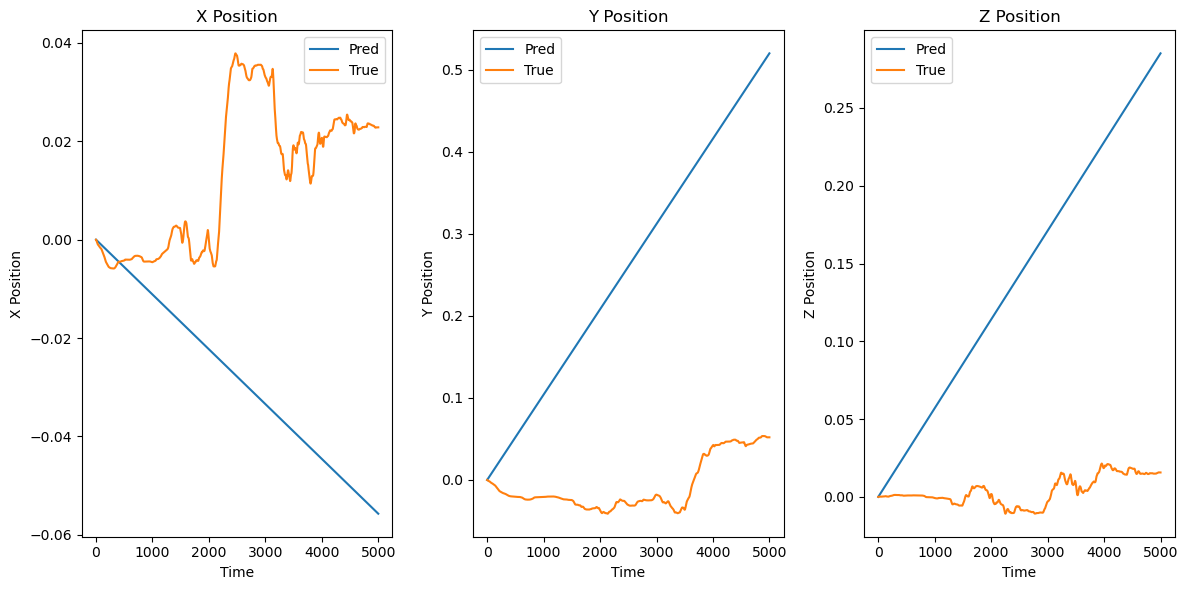

In [302]:
import numpy as np
import matplotlib.pyplot as plt

# Extract x, y, and z coordinates
posdif = model(torch.tensor(X,dtype=torch.float32))
print(posdif[:10,0].detach().numpy())
x_pred, y_pred, z_pred = np.zeros(stop), np.zeros(stop), np.zeros(stop)
x_true, y_true, z_true = np.zeros(stop), np.zeros(stop), np.zeros(stop)

for i in range(stop):
    x_pred[i] = np.sum(posdif[:i,0].detach().numpy())
    y_pred[i] = np.sum(posdif[:i,1].detach().numpy())
    z_pred[i] = np.sum(posdif[:i,2].detach().numpy())
    x_true[i] = np.sum(y[:i,0])
    y_true[i] = np.sum(y[:i,1])
    z_true[i] = np.sum(y[:i,2])

print(np.std(posdif[:,0].detach().numpy()))

# Create separate plots for each axis
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 6))

# Plot x axis
ax1.plot(x_pred,label='Pred')
ax1.plot(x_true,label='True')
ax1.set_xlabel('Time')
ax1.set_ylabel('X Position')
ax1.set_title('X Position')
ax1.legend()

# Plot y axis
ax2.plot(y_pred,label='Pred')
ax2.plot(y_true,label='True')
ax2.set_xlabel('Time')
ax2.set_ylabel('Y Position')
ax2.set_title('Y Position')
ax2.legend()

# Plot z axis
ax3.plot(z_pred,label='Pred')
ax3.plot(z_true,label='True')
ax3.set_xlabel('Time')
ax3.set_ylabel('Z Position')
ax3.set_title('Z Position')
ax3.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()